In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, datasets
import timm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
!pip install ultralytics
!pip install -U ipywidgets
!pip install gdown
!gdown 1_IzSXKcjpdrcxFLjkx8T9BVp6HjAln6X

import zipfile
with zipfile.ZipFile("Data.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [ ]:
!find /kaggle/working/data/Soda-drinks/ -type f | wc -l
!tree /kaggle/working/data/ -L 2

In [ ]:
import os
import random
import shutil

base_dir = '/kaggle/working/data/'

clothing_dir = os.path.join(base_dir, 'Clothing')
mobile_phones_dir = os.path.join(base_dir, 'Mobile-Phones')
soda_drinks_dir = os.path.join(base_dir, 'Soda-drinks')

train_dir = '/kaggle/working/yolov5_dataset/train'
val_dir = '/kaggle/working/yolov5_dataset/val'
test_dir = '/kaggle/working/yolov5_dataset/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def copy_images(images, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for img in images:
        shutil.copy(img, target_dir)

def get_random_split_images(src_dir, num_train=1000, num_val=100, num_test=100):
    all_images = []
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))

    random.shuffle(all_images)
    
    train_images = all_images[:num_train]
    val_images = all_images[num_train:num_train+num_val]
    test_images = all_images[num_train+num_val:num_train+num_val+num_test]
    
    return train_images, val_images, test_images

clothing_train, clothing_val, clothing_test = get_random_split_images(clothing_dir)
mobile_train, mobile_val, mobile_test = get_random_split_images(mobile_phones_dir)
soda_train, soda_val, soda_test = get_random_split_images(soda_drinks_dir)

copy_images(clothing_train, os.path.join(train_dir, 'Clothing'))
copy_images(clothing_val, os.path.join(val_dir, 'Clothing'))
copy_images(clothing_test, os.path.join(test_dir, 'Clothing'))

copy_images(mobile_train, os.path.join(train_dir, 'Mobile-Phones'))
copy_images(mobile_val, os.path.join(val_dir, 'Mobile-Phones'))
copy_images(mobile_test, os.path.join(test_dir, 'Mobile-Phones'))

copy_images(soda_train, os.path.join(train_dir, 'Soda-drinks'))
copy_images(soda_val, os.path.join(val_dir, 'Soda-drinks'))
copy_images(soda_test, os.path.join(test_dir, 'Soda-drinks'))

print("Images successfully splitted.")

In [ ]:
# Define transforms to convert images to tensors without normalization
compute_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=compute_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)

def calculate_mean_std(loader):
    # Initialize variables to store sum and squared sum
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    for images, _ in loader:
        batch_size = images.size(0)
        # Sum over batch, height and width (dimensions 0, 2, 3)
        mean += images.mean([0, 2, 3]) * batch_size
        std += images.std([0, 2, 3]) * batch_size
        total_images += batch_size

    mean /= total_images
    std /= total_images

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

In [ ]:
# Define transforms with RGB conversion
train_transforms = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transforms = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
# Hyperparameters

batch_size = 32
learning_rate = 1e-4
num_epochs = 5

best_val_accuracy = 0.0
patience = 3
trigger_times = 0

print_frequency = 20

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, 
                                     transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, 
                                   transform=validation_transforms)
test_dataset = datasets.ImageFolder(test_dir, 
                                    transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load the model and get its data configuration
model = timm.create_model('seresnextaa101d_32x8d.sw_in12k_ft_in1k_288', pretrained=True)
data_config = timm.data.resolve_model_data_config(model)

# Create training and validation transforms
train_transforms = timm.data.create_transform(**data_config, is_training=True)
val_transforms = timm.data.create_transform(**data_config, is_training=False)

In [ ]:
model = timm.create_model('seresnextaa101d_32x8d.sw_in12k_ft_in1k_288', pretrained=True, num_classes=3)
model = model.cuda()

full_train_dataset = datasets.ImageFolder(root='/kaggle/working/yolov5_dataset', transform=train_transforms)

# Class Imbalance
counter = Counter(full_train_dataset.targets)
class_counts = [counter[i] for i in range(len(counter))]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        
        if (batch_idx + 1) % print_frequency == 0:
            batch_loss = running_loss / ((batch_idx + 1) * inputs.size(0))
            batch_acc = correct_train / total_train
            print(f"Batch [{batch_idx+1}/{len(train_loader)}]: "
                  f"Train Loss: {batch_loss:.4f}, "
                  f"Train Acc: {batch_acc:.4f}")
            
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_train / total_train
    print(f'End of Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
    print(40*'#')
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = correct_val / total_val

    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    # Check for improvement
    if val_epoch_acc > best_val_accuracy:
        best_val_accuracy = val_epoch_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print("Early stopping!")
            break

    # Step the scheduler
    scheduler.step()

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.4f}')

# New Fixed Approcah

In [1]:
!pip install ultralytics
!pip install -U ipywidgets
!pip install gdown
!gdown 1_IzSXKcjpdrcxFLjkx8T9BVp6HjAln6X

import zipfile
with zipfile.ZipFile("Data.zip", "r") as zip_ref:
    zip_ref.extractall("data_dir")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.5/882.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [2]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, datasets
from torch import nn, optim
from torchvision import datasets, transforms, models
import timm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
import os, shutil

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
!find /kaggle/working/content/Soda-drinks/ -type f | wc -l
!tree /kaggle/working/content/ -L 2

find: '/kaggle/working/content/Soda-drinks/': No such file or directory
0
/kaggle/working/content/  [error opening dir]

0 directories, 0 files


In [4]:
# Paths to the source directories
Pants_dir = 'data_dir/Clothing/Pants'
T_Shirts_dir = 'data_dir/Clothing/T-Shirt'

Apple_dir = 'data_dir/Mobile-Phones/Apple'
Samsung_dir = 'data_dir/Mobile-Phones/Samsung'

Miranda_dir = 'data_dir/Soda-drinks/Miranda'
Pepsi_dir = 'data_dir/Soda-drinks/Pepsi'
Seven_Up_dir = 'data_dir/Soda-drinks/Seven-up'

# Path to the new data directory
merged_data_dir = 'data_dir/data'
merged_Soda_drinks_dir = os.path.join(merged_data_dir, 'Soda_drinks')
merged_Clothing_dir = os.path.join(merged_data_dir, 'Clothing')
merged_Mobile_Phones_dir = os.path.join(merged_data_dir, 'Mobile_Phones')

# Create new directories if they don't exist
os.makedirs(merged_Soda_drinks_dir, exist_ok=True)
os.makedirs(merged_Clothing_dir, exist_ok=True)
os.makedirs(merged_Mobile_Phones_dir, exist_ok=True)

def copy_files(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)
        dest_file = os.path.join(dest_dir, filename)
        shutil.copy(src_file, dest_file)

copy_files(Miranda_dir, merged_Soda_drinks_dir)
copy_files(Pepsi_dir, merged_Soda_drinks_dir)
copy_files(Seven_Up_dir, merged_Soda_drinks_dir)

copy_files(Pants_dir, merged_Clothing_dir)
copy_files(T_Shirts_dir, merged_Clothing_dir)

copy_files(Apple_dir, merged_Mobile_Phones_dir)
copy_files(Samsung_dir, merged_Mobile_Phones_dir)

print("Files merged successfully.")

Files merged successfully.


In [5]:
Clothing_dir = 'data_dir/data/Clothing'
Phones_dir = 'data_dir/data/Mobile_Phones'
Soda_drinks_dir = 'data_dir/data/Soda_drinks'

# Initialize lists to store information
file_extensions = {'Clothing': [], 'Phones': [], 'Soda_drinks':[]}
image_shapes = {'Clothing': [], 'Phones': [], 'Soda_drinks':[]}
image_sizes = {'Clothing': [], 'Phones': [], 'Soda_drinks':[]}

# Function to explore images in a directory
def explore_images(directory, label):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            with Image.open(file_path) as img:
                # Get file extension
                ext = filename.split('.')[-1].lower()
                file_extensions[label].append(ext)

                # Get image shape
                shape = img.size  # (width, height)
                image_shapes[label].append(shape)

                # Get image size in bytes
                size = os.path.getsize(file_path)
                image_sizes[label].append(size)
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

explore_images(Clothing_dir, 'Clothing')
explore_images(Phones_dir, 'Phones')
explore_images(Soda_drinks_dir, 'Soda_drinks')

print(f"Clothing Image Extensions: {set(file_extensions['Clothing'])}")
print(f"Phones Image Extensions: {set(file_extensions['Phones'])}")
print(f"Soda_drinks Image Extensions: {set(file_extensions['Soda_drinks'])}")
print(40*'#')

print(f"Clothing Image Sizes (min, max): {min(image_sizes['Clothing'])} bytes, {max(image_sizes['Clothing'])} bytes")
print(f"Phones Image Sizes (min, max): {min(image_sizes['Phones'])} bytes, {max(image_sizes['Phones'])} bytes")
print(f"Soda_drinks Image Sizes (min, max): {min(image_sizes['Soda_drinks'])} bytes, {max(image_sizes['Soda_drinks'])} bytes")
print(40*'#')

# Count the number of images in each class
num_Clothing_images = len(os.listdir(Clothing_dir))
num_Phones_images = len(os.listdir(Phones_dir))
num_Soda_drinks_images = len(os.listdir(Soda_drinks_dir))

num_Clothing_images, num_Phones_images, num_Soda_drinks_images

Clothing Image Extensions: {'bmp', 'webp', 'gif', 'jpg', 'jpeg', 'png'}
Phones Image Extensions: {'jpg'}
Soda_drinks Image Extensions: {'webp', 'jfif', 'gif', 'jpg', 'jpeg', 'png'}
########################################
Clothing Image Sizes (min, max): 2478 bytes, 7918274 bytes
Phones Image Sizes (min, max): 657 bytes, 9413 bytes
Soda_drinks Image Sizes (min, max): 775 bytes, 4370575 bytes
########################################


(1597, 42453, 1187)

In [12]:
# Hyperparameters

img_mode = 'RGBA'
img_resizer = (224, 224) # Best Practise
mean_ImgNet = np.array([0.485, 0.456, 0.406])
std_ImgNet = np.array([0.229, 0.224, 0.225])

train_set_fraction = 0.9
unknown_threshold = 0.9

batch_size = 32
learning_rate = 0.001
epochs = 10
best_val_acc = 0.0

In [13]:
data_dir = 'data_dir/data'

def convert_to_rgb(image):
    if image.mode in ('P', img_mode):
        return image.convert('RGB')
    return image

train_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # Convert to RGB
    transforms.Resize(img_resizer),      # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Augmentation: randomly flip images
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean_ImgNet, std_ImgNet)  # Normalize with ImageNet mean and std
])

val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # Convert to RGB
    transforms.Resize(img_resizer),      # Resize images to 224x224
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean_ImgNet, std_ImgNet)  # Normalize with ImageNet mean and std
])

# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

In [14]:
train_size = int(train_set_fraction * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply validation transforms to validation set
val_dataset.dataset.transform = val_transform

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
"""
# Load resnet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 classes
"""

# Load EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Replace the classifier layer with a new one for 3 classes
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 3)  # 3 classes + 1 for nothing

print(device)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_val_acc:.4f}')

Epoch 1/10
Train Loss: 0.0289 Acc: 0.9921
Val Loss: 0.0032 Acc: 0.9991

Classification Report:
               precision    recall  f1-score   support

     Clothing       1.00      0.98      0.99       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       0.98      0.99      0.98       123

     accuracy                           1.00      4523
    macro avg       0.99      0.99      0.99      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 2/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0088 Acc: 0.9972
Val Loss: 0.0040 Acc: 0.9991

Classification Report:
               precision    recall  f1-score   support

     Clothing       1.00      0.98      0.99       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       0.98      0.99      0.98       123

     accuracy                           1.00      4523
    macro avg       0.99      0.99      0.99      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 3/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0063 Acc: 0.9983
Val Loss: 0.0042 Acc: 0.9985

Classification Report:
               precision    recall  f1-score   support

     Clothing       1.00      0.96      0.98       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       0.95      0.99      0.97       123

     accuracy                           1.00      4523
    macro avg       0.98      0.98      0.98      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 4/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0071 Acc: 0.9981
Val Loss: 0.0018 Acc: 0.9996

Classification Report:
               precision    recall  f1-score   support

     Clothing       0.99      1.00      1.00       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       1.00      0.99      1.00       123

     accuracy                           1.00      4523
    macro avg       1.00      1.00      1.00      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 5/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0056 Acc: 0.9984
Val Loss: 0.0020 Acc: 0.9996

Classification Report:
               precision    recall  f1-score   support

     Clothing       1.00      0.99      1.00       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       1.00      0.99      1.00       123

     accuracy                           1.00      4523
    macro avg       1.00      0.99      1.00      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 6/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0048 Acc: 0.9987
Val Loss: 0.0059 Acc: 0.9987

Classification Report:
               precision    recall  f1-score   support

     Clothing       0.99      0.97      0.98       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       1.00      0.98      0.99       123

     accuracy                           1.00      4523
    macro avg       1.00      0.98      0.99      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 7/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0060 Acc: 0.9981
Val Loss: 0.0011 Acc: 0.9996

Classification Report:
               precision    recall  f1-score   support

     Clothing       1.00      0.99      1.00       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       0.99      0.99      0.99       123

     accuracy                           1.00      4523
    macro avg       1.00      0.99      1.00      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 8/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0047 Acc: 0.9986
Val Loss: 0.0064 Acc: 0.9987

Classification Report:
               precision    recall  f1-score   support

     Clothing       0.98      0.99      0.98       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       0.98      0.99      0.99       123

     accuracy                           1.00      4523
    macro avg       0.99      0.99      0.99      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 9/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0041 Acc: 0.9987
Val Loss: 0.0034 Acc: 0.9991

Classification Report:
               precision    recall  f1-score   support

     Clothing       0.99      0.99      0.99       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       0.99      0.99      0.99       123

     accuracy                           1.00      4523
    macro avg       0.99      0.99      0.99      4523
 weighted avg       1.00      1.00      1.00      4523

Epoch 10/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0038 Acc: 0.9989
Val Loss: 0.0038 Acc: 0.9989

Classification Report:
               precision    recall  f1-score   support

     Clothing       1.00      0.97      0.99       136
Mobile_Phones       1.00      1.00      1.00      4264
  Soda_drinks       0.98      0.99      0.98       123

     accuracy                           1.00      4523
    macro avg       0.99      0.99      0.99      4523
 weighted avg       1.00      1.00      1.00      4523

Best Validation Accuracy: 0.9996


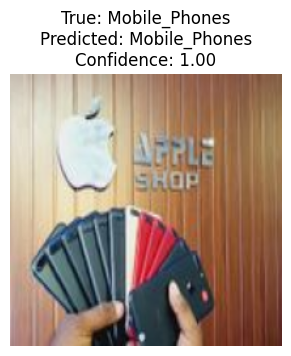

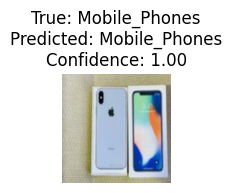

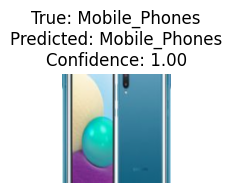

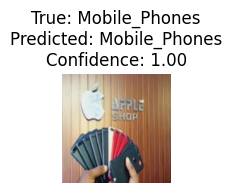

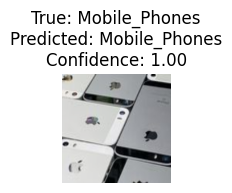

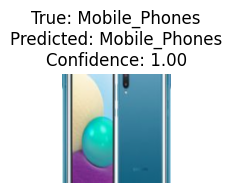

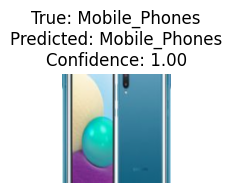

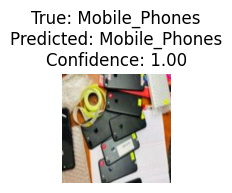

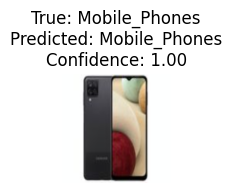

In [17]:
# Function to display image along with the title
def imshow(image, title=None):
    # Undo the normalization (reverse mean and std)
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axis
    plt.pause(0.001)  # Pause for a short time so the plot updates

# Function to show random images along with true and predicted labels
def show_random_prediction():
    model.eval()  # Set the model to evaluation mode

    # Load one random batch from validation data
    inputs, labels = next(iter(val_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probabilities, 1)
        #_, preds = torch.max(outputs, 1)

    # Move inputs, labels, and predictions back to CPU for visualization
    inputs = inputs.cpu()
    labels = labels.cpu()
    max_probs = max_probs.cpu()
    preds = preds.cpu()

    # Display multiple images along with their predictions
    plt.figure(figsize=(12, 12))

    for i in range(9): 
        rand_idx = np.random.randint(0, len(inputs))  # Pick a random index

        pred_label = dataset.classes[preds[rand_idx]] if max_probs[rand_idx] >= unknown_threshold else "Unknown"
        title = f"True: {dataset.classes[labels[rand_idx]]}\nPredicted: {pred_label}\nConfidence: {max_probs[rand_idx]:.2f}"
        
        plt.subplot(3, 3, i+1)  # Create a 3x3 grid of images
        imshow(inputs[rand_idx], title=title)

    plt.show()

show_random_prediction()

In [18]:
import requests
from PIL import Image
import os

# Function to download an image from a URL
def download_image(url, filename='unknown_image.jpg'):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as out_file:
            out_file.write(response.content)
        print("Image downloaded successfully.")
    else:
        print("Failed to download image.")
    return filename

# Replace this URL with an image link of something outside your classes
image_url = "https://hatrabbits.com/wp-content/uploads/2017/01/random.jpg"
image_path = download_image(image_url)

# Load the downloaded image and preprocess it
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = val_transform(image)  # Use the same transform as val_transform
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Predict on the downloaded image
def predict_downloaded_image(image_tensor, threshold=unknown_threshold):
    model.eval()
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        max_prob, pred_class_idx = torch.max(probabilities, dim=0)
        
        # Display prediction and confidence level
        pred_label = dataset.classes[pred_class_idx] if max_prob >= threshold else "Unknown"
        print(f"Predicted class: {pred_label}, Confidence: {max_prob.item():.2f}")

    return image_tensor

# Process and display the downloaded image
image_tensor = preprocess_image(image_path)
predict_downloaded_image(image_tensor)


# Process and display the downloaded image
image_tensor = preprocess_image(image_path)
predict_downloaded_image(image_tensor)

Image downloaded successfully.
Predicted class: Clothing, Confidence: 1.00
Predicted class: Clothing, Confidence: 1.00


tensor([[[[-0.1486, -0.1486, -0.1486,  ..., -0.1486, -0.1486, -0.1486],
          [-0.1486, -0.1486, -0.1486,  ..., -0.1486, -0.1486, -0.1486],
          [-0.1486, -0.1486, -0.1486,  ..., -0.1486, -0.1486, -0.1486],
          ...,
          [-1.5699, -1.5699, -1.5699,  ..., -1.5699, -1.5699, -1.5699],
          [-1.5699, -1.5699, -1.5699,  ..., -1.5699, -1.5699, -1.5699],
          [-1.5699, -1.5699, -1.5699,  ..., -1.5699, -1.5699, -1.5699]],

         [[ 1.0280,  1.0280,  1.0280,  ...,  1.0280,  1.0280,  1.0280],
          [ 1.0280,  1.0280,  1.0280,  ...,  1.0280,  1.0280,  1.0280],
          [ 1.0280,  1.0280,  1.0280,  ...,  1.0280,  1.0280,  1.0280],
          ...,
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731],
          [-1.7731, -1.7731, -1.7731,  ..., -1.7731, -1.7731, -1.7731]],

         [[ 1.4200,  1.4200,  1.4200,  ...,  1.4200,  1.4200,  1.4200],
          [ 1.4200,  1.4200,  